# **Music Recommendation System - EfficientNet B0**

## **1. Setup & Data Loading**



Drive Link for Cleaned and split data : [https://drive.google.com/drive/folders/1p7if9OludoXyG-R9y96LFIhwjTogucB9?usp=sharing]

In [1]:
# Install required packages
!pip install -q scikit-learn matplotlib seaborn
!pip install -q keras-tuner

# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import math


from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support


import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.applications import EfficientNetB0
#from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D
#from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

2025-11-08 04:25:51.888516: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762575951.910893     109 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762575951.917705     109 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
# Check GPU availability
print("GPU Available:", tf.config.list_physical_devices('GPU'))
print("TensorFlow version:", tf.__version__)

GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
TensorFlow version: 2.18.0


In [3]:
# Configuration
DRIVE_PATH = Path("/kaggle/input/emotion-recognition-cleaned-data") 
MODEL_SAVE_PATH = Path("/kaggle/working")
MODEL_SAVE_PATH.mkdir(exist_ok=True)


TARGET_CLASSES = ['angry', 'happy', 'sad', 'stressed', 'neutral']
IMG_SIZE = (48, 48)
BATCH_SIZE = 25
EPOCHS = 75
LEARNING_RATE = 0.001

In [4]:
# Load cleaned data from drive

train_data = np.load(DRIVE_PATH / "train.npz")
val_data = np.load(DRIVE_PATH / "val.npz")
test_data = np.load(DRIVE_PATH / "test.npz")

#unpacking the data from  .npz files into separate variables for easier use.
X_train, y_train = train_data['images'], train_data['labels']
X_val, y_val = val_data['images'], val_data['labels']
X_test, y_test = test_data['images'], test_data['labels']

# Clean up to free memory
train_data.close()
val_data.close()
test_data.close()
del train_data, val_data, test_data

print("Successfully loaded and unpacked the datasets from Drive.")

Successfully loaded and unpacked the datasets from Drive.


## **2. Data set Overview**

In [5]:
# Dataset Shape
print(f"Dataset shapes:")
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


print (" ")

# Dataset Labels
print("Label shapes:", y_train.shape, y_val.shape, y_test.shape)
print("Sample labels:", y_train[:10])
print("Unique labels:", np.unique(y_train))

print (" ")

##### Calculate Data count per class

# Count occurrences per set
train_counts = [np.sum(y_train == i) for i in range(len(TARGET_CLASSES))]
val_counts = [np.sum(y_val == i) for i in range(len(TARGET_CLASSES))]
test_counts = [np.sum(y_test == i) for i in range(len(TARGET_CLASSES))]

# Create table
table = pd.DataFrame({
    'Class Index': range(len(TARGET_CLASSES)),
    'Class Name': TARGET_CLASSES,
    'Train Count': train_counts,
    'Validation Count': val_counts,
    'Test Count': test_counts
})

# Add total row
total_row = pd.DataFrame({
    'Class Index': ['-'],
    'Class Name': ['Total'],
    'Train Count': [np.sum(train_counts)],
    'Validation Count': [np.sum(val_counts)],
    'Test Count': [np.sum(test_counts)]
})

table = pd.concat([table, total_row], ignore_index=True)

print(table)

Dataset shapes:
Train: (21970, 48, 48), Val: (5495, 48, 48), Test: (7092, 48, 48)
 
Label shapes: (21970,) (5495,) (7092,)
Sample labels: [3 3 3 2 3 1 2 4 1 2]
Unique labels: [0 1 2 3 4]
 
  Class Index Class Name  Train Count  Validation Count  Test Count
0           0      angry         3383               846        1055
1           1      happy         5668              1417        1767
2           2        sad         3779               945        1241
3           3   stressed         5250              1313        1804
4           4    neutral         3890               974        1225
5           -      Total        21970              5495        7092


- This confirms  labels are integer-encoded, not one-hot encoded.
- range from 0 to 4
- so use ->  *sparse_categorical_crossentropy*







## **3. Class Weight Calculation**



In [6]:
#calculated only for train set.
#For imbalance handling

print("\nCalculating class weights (training set only)...")
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = {i: weight for i, weight in enumerate(class_weights_array)}
print("Class weights:")
for i, (cls, weight) in enumerate(zip(TARGET_CLASSES, class_weights_array)):
    print(f"  {cls}: {weight:.3f}")



Calculating class weights (training set only)...
Class weights:
  angry: 1.299
  happy: 0.775
  sad: 1.163
  stressed: 0.837
  neutral: 1.130


## **4. Data Preprocessing**

In [7]:
def preprocess_images(images):

    print(f"Preprocessing {images.shape[0]} images...")

    # Convert pixel values to float32 and normalize to [0, 1]
    images = images.astype('float32') / 255.0

    # Add a channel dimension if missing
    if len(images.shape) == 3:
        images = images[..., np.newaxis]

    return images  #Return the processed images as single-channel (grayscale


In [8]:
# Preprocess all datasets
X_train = preprocess_images(X_train)
X_val = preprocess_images(X_val)
X_test = preprocess_images(X_test)

print(f"After preprocessing:")
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# Free memory
import gc
gc.collect()

Preprocessing 21970 images...
Preprocessing 5495 images...
Preprocessing 7092 images...
After preprocessing:
Train: (21970, 48, 48, 1), Val: (5495, 48, 48, 1), Test: (7092, 48, 48, 1)


0

## **5. Data Augmentation & Data Generators**



- Augmentation - for Train set only


      - Rotation(10%)
      - Horizontal flip
      -  Zoom (0.1)

- Data generators - for Train and validation  only


In [9]:
# Data Augmentation (aggressive for better generalization)
train_datagen = ImageDataGenerator(
#     rotation_range=10,           # Slight head tilt
#     horizontal_flip=True,        # Mirror faces
#     zoom_range=0.1,             # Small zoom in/out
#     brightness_range=[0.9, 1.1], # Subtle lighting
#     fill_mode='nearest'
 )

# No augmentation for validation/test
val_datagen = ImageDataGenerator()

In [10]:
# Create data generators (not for test set)
print("Creating data generators...")
train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True)
val_generator = val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE, shuffle=False)


Creating data generators...


## **6. Model Architecture Design**

- Build EfficientNet B0 architecture from scratch


      - Expansion phase:
      Temporarily increase the number of channels to let the block learn more features by expand_ratio (if >1)

      - Depthwise conv:
      extract spatial features per channel without increasing channels

      - Squeeze-Excitation (SE):
       Learns which channels are important → scales them.Improves model’s ability to focus on relevant features.

      - Dropout:
      Regularization-Randomly drops some features → prevents overfitting.(if dropout_rate > 0)

      - Projection phase:
      Reduces channels back to desired output_filters.

      - Skip connection:
      Adds input to output if shapes match → helps gradient flow, stabilizes training.

      - All layers:
      BatchNorm + Swish activation



In [11]:
# Define MBConv block for EfficientNet

def mbconv_block(inputs,    #input tensor
                 input_filters,    #number of channels in the input.
                 output_filters,   #number of channels to output after the block.
                 kernel_size=3,    #size of convolution filter
                 strides=1,     #step size for moving the filter
                 expand_ratio=1,   #how much to expand channels before depthwise conv
                 se_ratio=0.25,   #how much to reduce channels inside the squeeze-excitation step
                 block_id=0,    #block number- unique
                 dropout_rate=0.0):  #how much dropout to apply (regularization)


    prefix = f'block{block_id}_'   #name for the block’s layers
    filters = input_filters * expand_ratio  #channel size inside the block


    # Expansion phase
    if expand_ratio != 1:
        x = layers.Conv2D(filters, 1, padding='same', use_bias=False, name=prefix + 'expand_conv')(inputs)
        x = layers.BatchNormalization(name=prefix + 'expand_bn')(x)
        x = layers.Activation('swish', name=prefix + 'expand_activation')(x)
    else:
        x = inputs  #no expansion needed, just pass input as-is

    # Depthwise convolution
    x = layers.DepthwiseConv2D(kernel_size, strides=strides, padding='same', use_bias=False, name=prefix + 'dwconv')(x)
    x = layers.BatchNormalization(name=prefix + 'bn')(x)
    x = layers.Activation('swish', name=prefix + 'activation')(x)

    # Squeeze and Excitation
    if se_ratio > 0:
        se_filters = max(1, int(input_filters * se_ratio))
        se = layers.GlobalAveragePooling2D(name=prefix + 'se_squeeze')(x)
        se = layers.Reshape((1, 1, filters), name=prefix + 'se_reshape')(se)
        se = layers.Conv2D(se_filters, 1, activation='swish', name=prefix + 'se_reduce')(se)
        se = layers.Conv2D(filters, 1, activation='sigmoid', name=prefix + 'se_expand')(se)
        x = layers.Multiply(name=prefix + 'se_excite')([x, se])

    # Add dropout for regularization
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate, name=prefix + 'dropout')(x)

    # Projection phase
    x = layers.Conv2D(output_filters, 1, padding='same', use_bias=False, name=prefix + 'project_conv')(x)
    x = layers.BatchNormalization(name=prefix + 'project_bn')(x)

    # Skip connection
    if strides == 1 and input_filters == output_filters:
        x = layers.Add(name=prefix + 'add')([inputs, x])

    return x

## **7.Model Build**

    - Input: 48×48×1 grayscale images
    - Tunable stem conv:   First layer (24-48 filters, step 8, default 32)
    - 16 MBConv blocks:  Progressively increase channels (16→24→40→80→112→192→320)
    - Tunable parameters:  mbconv_dropout (0.0-0.2), se_ratio (0.1-0.3)
    - Top conv:   1×1 conv with tunable filters (1024-1536, default 1280)
    - Global pooling:    Reduces spatial dims to single vector
    - Classification head: 3 dense layers (tunable units + dropout)
    - Output:    Softmax for multi-class classification
    - Optimizer:   Adam with tunable learning rate (1e-4 to 1e-2, log scale)

In [12]:
def build_model(hp):

    #input(48*48*1)
    inputs = layers.Input(shape=(48, 48, 1), name='grayscale_input')

    # Tunable stem conv layer
    stem_filters = hp.Int('stem_filters', min_value=24, max_value=48, step=8, default=32)

    x = layers.Conv2D(stem_filters, 3, strides=2, padding='same', use_bias=False,
                     kernel_initializer='he_normal', name='stem_conv')(inputs)
    x = layers.BatchNormalization(name='stem_bn')(x)
    x = layers.Activation('swish', name='stem_activation')(x)

    # Tunable dropout rate for MBConv blocks
    mbconv_dropout = hp.Float('mbconv_dropout', min_value=0.0, max_value=0.2, step=0.05, default=0.1)

    # Tunable SE ratio
    se_ratio = hp.Float('se_ratio', min_value=0.1, max_value=0.3, step=0.05, default=0.25)

    # MBConv blocks with tunable parameters
    x = mbconv_block(x, stem_filters, 16, kernel_size=3, strides=1, expand_ratio=1,
                    se_ratio=se_ratio, block_id=0, dropout_rate=mbconv_dropout)

    x = mbconv_block(x, 16, 24, kernel_size=3, strides=2, expand_ratio=6,
                    se_ratio=se_ratio, block_id=1, dropout_rate=mbconv_dropout)
    x = mbconv_block(x, 24, 24, kernel_size=3, strides=1, expand_ratio=6,
                    se_ratio=se_ratio, block_id=2, dropout_rate=mbconv_dropout)

    x = mbconv_block(x, 24, 40, kernel_size=5, strides=2, expand_ratio=6,
                    se_ratio=se_ratio, block_id=3, dropout_rate=mbconv_dropout)
    x = mbconv_block(x, 40, 40, kernel_size=5, strides=1, expand_ratio=6,
                    se_ratio=se_ratio, block_id=4, dropout_rate=mbconv_dropout)

    x = mbconv_block(x, 40, 80, kernel_size=3, strides=2, expand_ratio=6,
                    se_ratio=se_ratio, block_id=5, dropout_rate=mbconv_dropout)
    x = mbconv_block(x, 80, 80, kernel_size=3, strides=1, expand_ratio=6,
                    se_ratio=se_ratio, block_id=6, dropout_rate=mbconv_dropout)
    x = mbconv_block(x, 80, 80, kernel_size=3, strides=1, expand_ratio=6,
                    se_ratio=se_ratio, block_id=7, dropout_rate=mbconv_dropout)

    x = mbconv_block(x, 80, 112, kernel_size=5, strides=1, expand_ratio=6,
                    se_ratio=se_ratio, block_id=8, dropout_rate=mbconv_dropout)
    x = mbconv_block(x, 112, 112, kernel_size=5, strides=1, expand_ratio=6,
                    se_ratio=se_ratio, block_id=9, dropout_rate=mbconv_dropout)
    x = mbconv_block(x, 112, 112, kernel_size=5, strides=1, expand_ratio=6,
                    se_ratio=se_ratio, block_id=10, dropout_rate=mbconv_dropout)

    x = mbconv_block(x, 112, 192, kernel_size=5, strides=2, expand_ratio=6,
                    se_ratio=se_ratio, block_id=11, dropout_rate=mbconv_dropout)
    x = mbconv_block(x, 192, 192, kernel_size=5, strides=1, expand_ratio=6,
                    se_ratio=se_ratio, block_id=12, dropout_rate=mbconv_dropout)
    x = mbconv_block(x, 192, 192, kernel_size=5, strides=1, expand_ratio=6,
                    se_ratio=se_ratio, block_id=13, dropout_rate=mbconv_dropout)
    x = mbconv_block(x, 192, 192, kernel_size=5, strides=1, expand_ratio=6,
                    se_ratio=se_ratio, block_id=14, dropout_rate=mbconv_dropout)

    x = mbconv_block(x, 192, 320, kernel_size=3, strides=1, expand_ratio=6,
                    se_ratio=se_ratio, block_id=15, dropout_rate=mbconv_dropout)

    # Tunable top conv filters
    top_filters = hp.Int('top_filters', min_value=1024, max_value=1536, step=128, default=1280)
    x = layers.Conv2D(top_filters, 1, padding='same', use_bias=False, name='top_conv')(x)
    x = layers.BatchNormalization(name='top_bn')(x)
    x = layers.Activation('swish', name='top_activation')(x)
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)

    # Tunable classification head
    dense1_units = hp.Int('dense1_units', min_value=256, max_value=768, step=128, default=512)
    dense1_dropout = hp.Float('dense1_dropout', min_value=0.3, max_value=0.7, step=0.1, default=0.5)

    dense2_units = hp.Int('dense2_units', min_value=128, max_value=384, step=64, default=256)
    dense2_dropout = hp.Float('dense2_dropout', min_value=0.2, max_value=0.5, step=0.1, default=0.3)

    dense3_units = hp.Int('dense3_units', min_value=64, max_value=192, step=32, default=128)
    dense3_dropout = hp.Float('dense3_dropout', min_value=0.1, max_value=0.4, step=0.1, default=0.2)

    x = layers.Dense(dense1_units, activation='relu', name='dense_1')(x)
    x = layers.Dropout(dense1_dropout, name='dropout_1')(x)
    x = layers.Dense(dense2_units, activation='relu', name='dense_2')(x)
    x = layers.Dropout(dense2_dropout, name='dropout_2')(x)
    x = layers.Dense(dense3_units, activation='relu', name='dense_3')(x)
    x = layers.Dropout(dense3_dropout, name='dropout_3')(x)


    #Output Layer
    outputs = layers.Dense(len(TARGET_CLASSES), activation='softmax', name='classification_head')(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='efficientnetb0_grayscale_tuned')

    # Tunable learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2,
                           sampling='LOG', default=1e-3)

    # Model Compilation
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=SparseCategoricalCrossentropy(from_logits=False), #false -> model’s final layer uses softmax activation
        metrics=[SparseCategoricalAccuracy(name='accuracy')]
    )

    return model


## **8. Hyperparameter Tuning**

- Automatically finds best hyperparameters for the model using Keras Tuner

      - Initializes RandomSearch tuner - tests different hyperparameter combinations
      - Sets up callbacks - EarlyStopping + ReduceLROnPlateau for efficient training
      - Runs search - trains 30 epochs per trial, evaluates on validation data
      - Finds best hyperparameters - selects top performing configuration

In [13]:
def run_hyperparameter_tuning(X_train, y_train, X_val, y_val, class_weights, max_trials=20):


    print(f"Starting tuning with {max_trials} trials...")

    # Initialize tuner- Uses RandomSearch from Keras Tuner
    tuner = kt.RandomSearch(   #tries random hyperparameter combinations
        hypermodel=build_model,  #builds the  model (with tunable params)
        objective='val_accuracy', # Maximize val_accuracy
        max_trials=max_trials,  # number of hyperparameter sets to test. (default 20)
        executions_per_trial=1,
        directory='/kaggle/working/tuner_results',  #save directory in drive
        project_name='efficientnet_emotion'
    )

    # Callbacks
    callbacks = [
        #Stops if val_accuracy doesn't improve (patience=5)
        EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
        #Reduces learning rate if val_loss plateaus (patience=3)
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)
    ]

    # Search for Best Hyperparameters
    tuner.search( #runs training multiple times with different hyperparameters.
        X_train, y_train,
        validation_data=(X_val, y_val),  # evaluates each model on val set.
        epochs=30,   #Trains each configuration for 30 epochs
        batch_size=BATCH_SIZE, #mini-batch size during training.
        class_weight=class_weights,  #class weights for imbalanced data
        callbacks=callbacks,
        verbose=1
    )

    # Returns tuner object and best hyperparameters
    best_hps = tuner.get_best_hyperparameters(1)[0]

    print("\n" + "-"*60)
    print("\nBest hyperparameters:")
    for key in ['learning_rate', 'stem_filters', 'top_filters', 'se_ratio',
                'mbconv_dropout', 'dense1_units', 'dense1_dropout']:
        print(f"{key}: {best_hps.get(key)}")

    return tuner, best_hps

## **9.Model Training**

* Check if hyperparameter tuning is enabled

         - if yes:
         Runs run_hyperparameter_tuning()
         Picks the best hyperparameters.
         Builds the best model with them.

         - if no:
         Builds a model with default hyperparameters.
         Compiles it with Adam optimizer and categorical loss.

* Set up callbacks for final training
* Train the final model
           
       

In [14]:
def main_training_pipeline(use_hyperparameter_tuning=True, max_trials=20):

    # Calculate class weights
    # class_weights = calculate_class_weights(y_train)
    # print("Class weights:", class_weights)


    #If tuning enabled:
    if use_hyperparameter_tuning:
        print("\n" + "="*60)
        print("Running Hyperparameter Tuning")
        print("="*60)

        # Run hyperparameter tuning
        tuner, best_hps = run_hyperparameter_tuning(
            X_train, y_train, X_val, y_val, class_weights, max_trials
        )

        # Build best model
        print("\nBuilding best model with tuned hyperparameters...")
        model = tuner.hypermodel.build(best_hps)
        print("\nSuccessfully build the best model.")

        # # Display best model summary
        # print("\nBest model summary:")
        # model.summary()


    #If tuning disabled:Creates model with default hyperparameters
    else:
        print("\n" + "="*60)
        print("Using default hyperparameters..")
        print("="*60)

        # Create model with default hyperparameters
        model = create_emotion_model(input_shape=(48, 48, 1), num_classes=len(TARGET_CLASSES))

        # Compile the model
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss=SparseCategoricalCrossentropy(from_logits=False),
            metrics=[SparseCategoricalAccuracy(name='accuracy')]
        )

        # print("Model summary:")
        # model.summary()




    # Setup callbacks for final training
    callbacks = [

        #saves best model based on val_accuracy
        ModelCheckpoint(
            filepath=str(MODEL_SAVE_PATH / ('best_emotion_model_tuned.h5' if use_hyperparameter_tuning else 'best_emotion_model.h5')),
            monitor='val_accuracy',
            save_best_only=True,
            save_weights_only=False,
            mode='max',
            verbose=1
        ),

        #stops if no improvement (patience=15)
        EarlyStopping(
            monitor='val_accuracy',
            patience=15,  # Increased patience for final training
            restore_best_weights=True,
            verbose=1
        ),

        #reduces learning rate when stuck (patience=7)
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=7,
            min_lr=1e-7,
            verbose=1
        )
    ]

    # Train the final model
    print("\n" + "="*60)
    print("\nFinal Training.")
    print("="*60)
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")
    print(f"Batch size: {BATCH_SIZE}")

    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=val_generator,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )

    return model, history

## **10. Model Evaluation & Testing**

    - Plot training and validation \metrics
    - Comprehensive model evaluation
    

In [15]:
#Plot training metrics
def plot_training_history(history):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.set_title(f'Model Accuracy Over Time ({len(history.history["accuracy"])} epochs)')

    # Accuracy
    ax1.plot(history.history['accuracy'], label='Train')  #Plots training accuracy vs epochs.
    ax1.plot(history.history['val_accuracy'], label='Val') #Plots validation accuracy  vs epochs.
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Loss
    ax2.plot(history.history['loss'], label='Train')  #Plots training loss  vs epochs
    ax2.plot(history.history['val_loss'], label='Val') #Plots validation loss  vs epochs.
    ax2.set_title('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()


In [16]:
#Comprehensive model evaluation
def evaluate_model(model, X_test, y_test):

    print("\n" + "="*60)
    print("Model Evaluation")
    print("="*60)


    # Make Predictions
    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)

    #Compute weighted precision, recall, F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    print(f"\nWeighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")

    # Evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

    print("  ")
    # Classification report
    print("\n" + classification_report(y_test, y_pred, target_names=TARGET_CLASSES, digits=4))

    print("  ")
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=TARGET_CLASSES, yticklabels=TARGET_CLASSES)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    print("  ")
    # Per-class accuracy
    print("\nPer-class accuracy:")
    for i, name in enumerate(TARGET_CLASSES):
        print(f"{name}: {cm[i,i]/cm[i].sum():.4f}")

    return test_acc, cm


## **11. Prediction Function**


    - prepares a single image
    - normalizes it
    - predicts emotion
    - returns the predicted label, its confidence, and all class probabilities



In [17]:
#Predict emotion from single image
def predict_emotion(model, image):

    # Prepare image
    if len(image.shape) == 2:  #Check image shape-If image is grayscale (2D), adds a channel dimension (H, W, 1).
        image = image[..., np.newaxis]
    image = np.expand_dims(image, 0)  #Adds batch dimension → shape becomes (1, H, W, C).
    if image.max() > 1.0:
        image = image.astype('float32') / 255.0  #f pixel values are 0–255, scales them to 0–1 range

    # Gets prediction probabilities for each class.
    preds = model.predict(image, verbose=0)[0]
    pred_class = np.argmax(preds)

    return TARGET_CLASSES[pred_class], preds[pred_class], preds

## **12. Main execution script**

Trial 20 Complete [00h 04m 42s]
val_accuracy: 0.25787079334259033

Best val_accuracy So Far: 0.5550500750541687
Total elapsed time: 02h 25m 19s

------------------------------------------------------------

Best hyperparameters:
learning_rate: 0.0003379886371533295
stem_filters: 48
top_filters: 1280
se_ratio: 0.15000000000000002
mbconv_dropout: 0.1
dense1_units: 640
dense1_dropout: 0.5

Building best model with tuned hyperparameters...

Successfully build the best model.


Final Training.
Training samples: 21970
Validation samples: 5495
Batch size: 25
Epoch 1/75


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


877/879 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.2116 - loss: 1.6821
Epoch 1: val_accuracy improved from -inf to 0.20692, saving model to /kaggle/working/best_emotion_model_tuned.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 137s 74ms/step - accuracy: 0.2116 - loss: 1.6820 - val_accuracy: 0.2069 - val_loss: 1.6139 - learning_rate: 3.3799e-04
Epoch 2/75
877/879 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2365 - loss: 1.6071
Epoch 2: val_accuracy improved from 0.20692 to 0.28571, saving model to /kaggle/working/best_emotion_model_tuned.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.2365 - loss: 1.6071 - val_accuracy: 0.2857 - val_loss: 1.5549 - learning_rate: 3.3799e-04
Epoch 3/75
878/879 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2876 - loss: 1.5746
Epoch 3: val_accuracy improved from 0.28571 to 0.35978, saving model to /kaggle/working/best_emotion_model_tuned.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.2877 - loss: 1.5746 - val_accuracy: 0.3598 - val_loss: 1.4848 - learning_rate: 3.3799e-04
Epoch 4/75
877/879 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3540 - loss: 1.5213
Epoch 4: val_accuracy improved from 0.35978 to 0.39945, saving model to /kaggle/working/best_emotion_model_tuned.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.3540 - loss: 1.5212 - val_accuracy: 0.3995 - val_loss: 1.4475 - learning_rate: 3.3799e-04
Epoch 5/75
878/879 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3978 - loss: 1.4490
Epoch 5: val_accuracy improved from 0.39945 to 0.43967, saving model to /kaggle/working/best_emotion_model_tuned.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.3978 - loss: 1.4490 - val_accuracy: 0.4397 - val_loss: 1.3772 - learning_rate: 3.3799e-04
Epoch 6/75
878/879 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4263 - loss: 1.4117
Epoch 6: val_accuracy improved from 0.43967 to 0.44950, saving model to /kaggle/working/best_emotion_model_tuned.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.4263 - loss: 1.4117 - val_accuracy: 0.4495 - val_loss: 1.3303 - learning_rate: 3.3799e-04
Epoch 7/75
877/879 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4497 - loss: 1.3676
Epoch 7: val_accuracy improved from 0.44950 to 0.44986, saving model to /kaggle/working/best_emotion_model_tuned.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.4497 - loss: 1.3676 - val_accuracy: 0.4499 - val_loss: 1.3014 - learning_rate: 3.3799e-04
Epoch 8/75
877/879 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4639 - loss: 1.3434
Epoch 8: val_accuracy improved from 0.44986 to 0.45714, saving model to /kaggle/working/best_emotion_model_tuned.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.4639 - loss: 1.3434 - val_accuracy: 0.4571 - val_loss: 1.2847 - learning_rate: 3.3799e-04
Epoch 9/75
877/879 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4777 - loss: 1.3132
Epoch 9: val_accuracy improved from 0.45714 to 0.47843, saving model to /kaggle/working/best_emotion_model_tuned.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.4777 - loss: 1.3132 - val_accuracy: 0.4784 - val_loss: 1.2535 - learning_rate: 3.3799e-04
Epoch 10/75
877/879 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5007 - loss: 1.2780
Epoch 10: val_accuracy improved from 0.47843 to 0.50719, saving model to /kaggle/working/best_emotion_model_tuned.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.5007 - loss: 1.2780 - val_accuracy: 0.5072 - val_loss: 1.2430 - learning_rate: 3.3799e-04
Epoch 11/75
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5145 - loss: 1.2599
Epoch 11: val_accuracy did not improve from 0.50719
879/879 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.5145 - loss: 1.2599 - val_accuracy: 0.4699 - val_loss: 1.2899 - learning_rate: 3.3799e-04
Epoch 12/75
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5152 - loss: 1.2425
Epoch 12: val_accuracy did not improve from 0.50719
879/879 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.5152 - loss: 1.2425 - val_accuracy: 0.4952 - val_loss: 1.2519 - learning_rate: 3.3799e-04
Epoch 13/75
878/879 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5191 - loss: 1.2291
Epoch 13: val_accuracy did not improve from 0.50719
879/879 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.5191 - loss: 1.2290 - val_accuracy: 0.4990 - val_loss: 1.2330 - learning_rate: 3.3

879/879 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.5265 - loss: 1.2120 - val_accuracy: 0.5092 - val_loss: 1.2187 - learning_rate: 3.3799e-04
Epoch 15/75
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5485 - loss: 1.1743
Epoch 15: val_accuracy improved from 0.50919 to 0.51847, saving model to /kaggle/working/best_emotion_model_tuned.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.5485 - loss: 1.1743 - val_accuracy: 0.5185 - val_loss: 1.2064 - learning_rate: 3.3799e-04
Epoch 16/75
877/879 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5356 - loss: 1.1921
Epoch 16: val_accuracy did not improve from 0.51847
879/879 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.5356 - loss: 1.1921 - val_accuracy: 0.4719 - val_loss: 1.2899 - learning_rate: 3.3799e-04
Epoch 17/75
878/879 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5299 - loss: 1.2040
Epoch 17: val_accuracy did not improve from 0.51847
879/879 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.5298 - loss: 1.2041 - val_accuracy: 0.5076 - val_loss: 1.2239 - learning_rate: 3.3799e-04
Epoch 18/75
878/879 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5426 - loss: 1.1739
Epoch 18: val_accuracy improved from 0.51847 to 0.52375, saving model to /kaggle/working/best_emotion_model_tuned.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.5426 - loss: 1.1740 - val_accuracy: 0.5237 - val_loss: 1.1877 - learning_rate: 3.3799e-04
Epoch 19/75
878/879 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5391 - loss: 1.1957
Epoch 19: val_accuracy did not improve from 0.52375
879/879 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.5391 - loss: 1.1957 - val_accuracy: 0.4904 - val_loss: 1.3487 - learning_rate: 3.3799e-04
Epoch 20/75
877/879 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5587 - loss: 1.1670
Epoch 20: val_accuracy did not improve from 0.52375
879/879 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.5587 - loss: 1.1669 - val_accuracy: 0.5097 - val_loss: 1.2334 - learning_rate: 3.3799e-04
Epoch 21/75
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5586 - loss: 1.1616
Epoch 21: val_accuracy did not improve from 0.52375
879/879 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.5586 - loss: 1.1616 - val_accuracy: 0.5157 - val_loss: 1.2629 - learning_rate: 3.3

879/879 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.5694 - loss: 1.1148 - val_accuracy: 0.5429 - val_loss: 1.1491 - learning_rate: 3.3799e-04
Epoch 28/75
878/879 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5831 - loss: 1.0935
Epoch 28: val_accuracy did not improve from 0.54286
879/879 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - accuracy: 0.5831 - loss: 1.0935 - val_accuracy: 0.5328 - val_loss: 1.2017 - learning_rate: 3.3799e-04
Epoch 29/75
877/879 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5598 - loss: 1.1461
Epoch 29: val_accuracy did not improve from 0.54286
879/879 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5597 - loss: 1.1462 - val_accuracy: 0.5223 - val_loss: 1.1920 - learning_rate: 3.3799e-04
Epoch 30/75
878/879 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5518 - loss: 1.1742
Epoch 30: val_accuracy did not improve from 0.54286
879/879 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5518 - loss: 1.1742 - val_accuracy: 0.5287 - val_loss: 1.1647 - learning_rate: 3.3

879/879 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.5864 - loss: 1.0877 - val_accuracy: 0.5510 - val_loss: 1.1446 - learning_rate: 3.3799e-04
Epoch 33/75
878/879 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5860 - loss: 1.0901
Epoch 33: val_accuracy did not improve from 0.55105
879/879 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.5860 - loss: 1.0901 - val_accuracy: 0.5427 - val_loss: 1.1628 - learning_rate: 3.3799e-04
Epoch 34/75
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5925 - loss: 1.0687
Epoch 34: val_accuracy did not improve from 0.55105
879/879 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.5925 - loss: 1.0688 - val_accuracy: 0.5434 - val_loss: 1.1439 - learning_rate: 3.3799e-04
Epoch 35/75
877/879 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5662 - loss: 1.1289
Epoch 35: val_accuracy did not improve from 0.55105
879/879 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.5661 - loss: 1.1291 - val_accuracy: 0.5096 - val_loss: 1.2521 - learning_rate: 3.3

879/879 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.5951 - loss: 1.0550 - val_accuracy: 0.5518 - val_loss: 1.1202 - learning_rate: 1.6899e-04
Epoch 47/75
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5922 - loss: 1.0539
Epoch 47: val_accuracy did not improve from 0.55177
879/879 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.5922 - loss: 1.0539 - val_accuracy: 0.5403 - val_loss: 1.1241 - learning_rate: 1.6899e-04
Epoch 48/75
877/879 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6028 - loss: 1.0440
Epoch 48: val_accuracy improved from 0.55177 to 0.55341, saving model to /kaggle/working/best_emotion_model_tuned.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.6028 - loss: 1.0440 - val_accuracy: 0.5534 - val_loss: 1.1135 - learning_rate: 1.6899e-04
Epoch 49/75
877/879 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6155 - loss: 1.0171
Epoch 49: val_accuracy did not improve from 0.55341
879/879 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.6155 - loss: 1.0171 - val_accuracy: 0.5465 - val_loss: 1.1159 - learning_rate: 1.6899e-04
Epoch 50/75
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6160 - loss: 1.0118
Epoch 50: val_accuracy did not improve from 0.55341
879/879 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.6159 - loss: 1.0118 - val_accuracy: 0.5521 - val_loss: 1.1288 - learning_rate: 1.6899e-04
Epoch 51/75
877/879 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6244 - loss: 0.9998
Epoch 51: val_accuracy did not improve from 0.55341
879/879 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.6244 - loss: 0.9998 - val_accuracy: 0.5523 - val_loss: 1.1344 - learning_rate: 1.6

879/879 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.6332 - loss: 0.9737 - val_accuracy: 0.5603 - val_loss: 1.0964 - learning_rate: 1.6899e-04
Epoch 53/75
877/879 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6359 - loss: 0.9747
Epoch 53: val_accuracy improved from 0.56033 to 0.56233, saving model to /kaggle/working/best_emotion_model_tuned.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.6359 - loss: 0.9747 - val_accuracy: 0.5623 - val_loss: 1.1158 - learning_rate: 1.6899e-04
Epoch 54/75
877/879 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6358 - loss: 0.9762
Epoch 54: val_accuracy did not improve from 0.56233
879/879 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.6358 - loss: 0.9762 - val_accuracy: 0.5594 - val_loss: 1.1174 - learning_rate: 1.6899e-04
Epoch 55/75
877/879 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6348 - loss: 0.9611
Epoch 55: val_accuracy improved from 0.56233 to 0.56379, saving model to /kaggle/working/best_emotion_model_tuned.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.6348 - loss: 0.9611 - val_accuracy: 0.5638 - val_loss: 1.1301 - learning_rate: 1.6899e-04
Epoch 56/75
877/879 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6500 - loss: 0.9381
Epoch 56: val_accuracy did not improve from 0.56379
879/879 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.6500 - loss: 0.9381 - val_accuracy: 0.5581 - val_loss: 1.1178 - learning_rate: 1.6899e-04
Epoch 57/75
877/879 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6557 - loss: 0.9249
Epoch 57: val_accuracy did not improve from 0.56379
879/879 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.6557 - loss: 0.9249 - val_accuracy: 0.5571 - val_loss: 1.1263 - learning_rate: 1.6899e-04
Epoch 58/75
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6559 - loss: 0.9274
Epoch 58: val_accuracy did not improve from 0.56379
879/879 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.6559 - loss: 0.9274 - val_accuracy: 0.5601 - val_loss: 1.1466 - learning_rate: 1.6

879/879 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.6612 - loss: 0.9079 - val_accuracy: 0.5672 - val_loss: 1.1301 - learning_rate: 8.4497e-05
Epoch 62/75
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6742 - loss: 0.8767
Epoch 62: val_accuracy improved from 0.56724 to 0.56888, saving model to /kaggle/working/best_emotion_model_tuned.h5


879/879 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.6741 - loss: 0.8767 - val_accuracy: 0.5689 - val_loss: 1.1391 - learning_rate: 8.4497e-05
Epoch 63/75
877/879 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6789 - loss: 0.8726
Epoch 63: val_accuracy did not improve from 0.56888
879/879 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.6789 - loss: 0.8726 - val_accuracy: 0.5614 - val_loss: 1.1334 - learning_rate: 8.4497e-05
Epoch 64/75
877/879 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6649 - loss: 0.9062
Epoch 64: val_accuracy did not improve from 0.56888
879/879 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.6649 - loss: 0.9062 - val_accuracy: 0.5569 - val_loss: 1.1649 - learning_rate: 8.4497e-05
Epoch 65/75
877/879 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6681 - loss: 0.9018
Epoch 65: val_accuracy did not improve from 0.56888
879/879 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.6681 - loss: 0.9018 - val_accuracy: 0.5623 - val_loss: 1.1420 - learning_rate: 8.4

879/879 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.6873 - loss: 0.8440 - val_accuracy: 0.5707 - val_loss: 1.1512 - learning_rate: 4.2249e-05
Epoch 72/75
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6903 - loss: 0.8484
Epoch 72: val_accuracy did not improve from 0.57070
879/879 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.6903 - loss: 0.8484 - val_accuracy: 0.5689 - val_loss: 1.1538 - learning_rate: 4.2249e-05
Epoch 73/75
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6868 - loss: 0.8492
Epoch 73: val_accuracy did not improve from 0.57070

Epoch 73: ReduceLROnPlateau reducing learning rate to 2.1124289560248144e-05.
879/879 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.6868 - loss: 0.8492 - val_accuracy: 0.5696 - val_loss: 1.1604 - learning_rate: 4.2249e-05
Epoch 74/75
877/879 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6905 - loss: 0.8323
Epoch 74: val_accuracy did not improve from 0.57070
879/879 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.690

879/879 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - accuracy: 0.6948 - loss: 0.8381 - val_accuracy: 0.5711 - val_loss: 1.1509 - learning_rate: 2.1124e-05
Restoring model weights from the end of the best epoch: 75.

------------------------------------------------------------

Plotting training history...


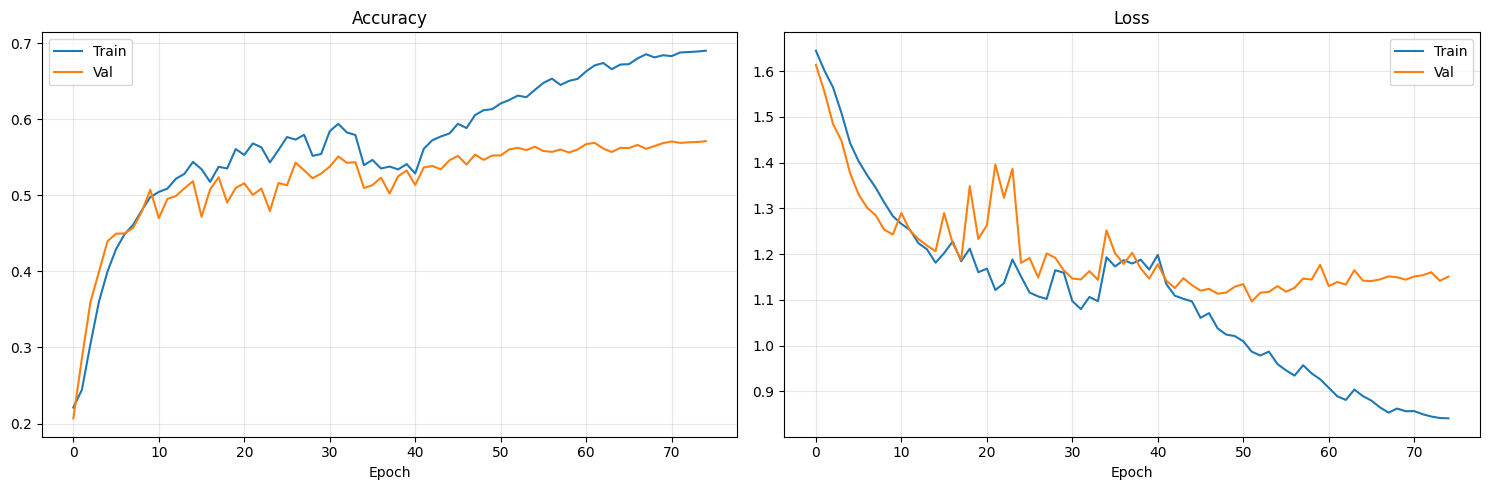


------------------------------------------------------------

Loading best model from /kaggle/working/best_emotion_model_tuned.h5...



Model Evaluation

Weighted Precision: 0.6002
Weighted Recall: 0.5768
Weighted F1-Score: 0.5823
Test Accuracy: 0.5768 | Test Loss: 1.1482
  

              precision    recall  f1-score   support

       angry     0.4981    0.4910    0.4945      1055
       happy     0.7585    0.7872    0.7726      1767
         sad     0.3671    0.4851    0.4179      1241
    stressed     0.7467    0.5310    0.6207      1804
     neutral     0.4803    0.5078    0.4937      1225

    accuracy                         0.5768      7092
   macro avg     0.5701    0.5604    0.5599      7092
weighted avg     0.6002    0.5768    0.5823      7092

  


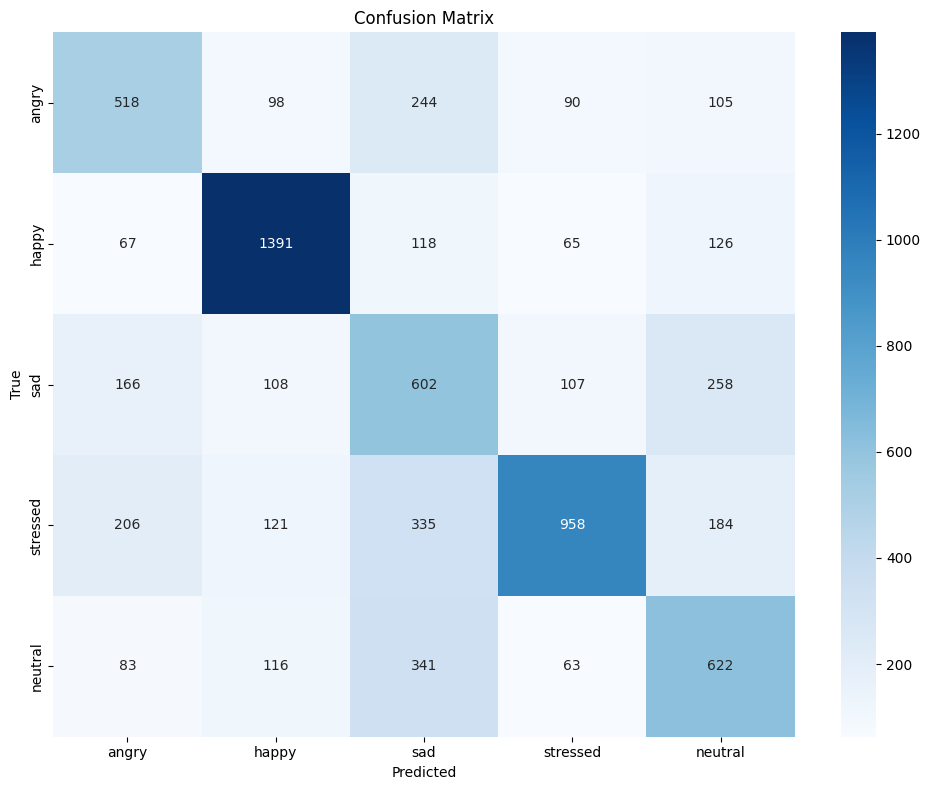

  

Per-class accuracy:
angry: 0.4910
happy: 0.7872
sad: 0.4851
stressed: 0.5310
neutral: 0.5078

------------------------------------------------------------

Testing prediction function:


True emotion: angry
Predicted emotion: sad
Confidence: 0.4350

------------------------------------------------------------

Saving final model as /kaggle/working/final_emotion_model_tuned.h5...

TRAINING COMPLETE!
Final test accuracy: 0.5768
Model saved as: /kaggle/working/final_emotion_model_tuned.h5
Model parameters: 4,698,452


In [18]:
if __name__ == "__main__":

    # Choose whether to use hyperparameter tuning
    USE_TUNING = True  # Set to False for faster training with default parameters

    MAX_TRIALS = 20

    print("="*60)
    print("Emotion recognition model training Start..")
    print("="*60)
    print(f"Using hyperparameter tuning: {USE_TUNING}")
    if USE_TUNING:
        print(f"Max tuning trials: {MAX_TRIALS}")  # MAX_TRIALS=20

    print("\n" + "-"*60)
    # Run the complete training pipeline
    model, history = main_training_pipeline(
        use_hyperparameter_tuning=USE_TUNING,
        max_trials=MAX_TRIALS
    )

    print("\n" + "-"*60)
    # Plot training history
    print("\nPlotting training history...")
    plot_training_history(history)

    print("\n" + "-"*60)
    # Load best model and evaluate
    model_path = MODEL_SAVE_PATH / ('best_emotion_model_tuned.h5' if USE_TUNING else 'best_emotion_model.h5')
    print(f"\nLoading best model from {model_path}...")
    model = keras.models.load_model(str(model_path))


    # Comprehensive evaluation
    test_accuracy, cm = evaluate_model(model, X_test, y_test)

    print("\n" + "-"*60)
    # Test prediction function
    print("\nTesting prediction function:")
    sample_idx = 0
    sample_image = X_test[sample_idx]
    true_emotion = TARGET_CLASSES[y_test[sample_idx]]

    predicted_emotion, confidence, all_probs = predict_emotion(model, sample_image)

    print(f"True emotion: {true_emotion}")
    print(f"Predicted emotion: {predicted_emotion}")
    print(f"Confidence: {confidence:.4f}")

    print("\n" + "-"*60)
    # Save final model
    final_model_name = MODEL_SAVE_PATH / ('final_emotion_model_tuned.h5' if USE_TUNING else 'final_emotion_model.h5')
    print(f"\nSaving final model as {final_model_name}...")
    model.save(str(final_model_name))


    print("\n" + "="*60)
    print("TRAINING COMPLETE!")
    print("="*60)
    print(f"Final test accuracy: {test_accuracy:.4f}")
    print(f"Model saved as: {final_model_name}")
    print(f"Model parameters: {model.count_params():,}")



In [19]:
print("\nBest model summary:")
model.summary()


Best model summary:


Model: "efficientnetb0_grayscale_tuned"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ grayscale_input     │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 24, 24,    │        432 │ grayscale_input[… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 24, 24,    │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 24, 24,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block0_dwconv       │ (None, 24, 24,    │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block0_bn           │ (None, 24, 24,    │        192 │ block0_dwconv[0]… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block0_activation   │ (None, 24, 24,    │          0 │ block0_bn[0][0]   │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block0_se_squeeze   │ (None, 48)        │          0 │ block0_activatio… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block0_se_reshape   │ (None, 1, 1, 48)  │          0 │ block0_se_squeez… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block0_se_reduce    │ (None, 1, 1, 7)   │        343 │ block0_se_reshap… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block0_se_expand    │ (None, 1, 1, 48)  │        384 │ block0_se_reduce… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block0_se_excite    │ (None, 24, 24,    │          0 │ block0_activatio… │
│ (Multiply)          │ 48)               │            │ block0_se_expand… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block0_dropout      │ (None, 24, 24,    │          0 │ block0_se_excite… │
│ (Dropout)           │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block0_project_conv │ (None, 24, 24,    │        768 │ block0_dropout[0… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block0_project_bn   │ (None, 24, 24,    │         64 │ block0_project_c… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_expand_conv  │ (None, 24, 24,    │      1,536 │ block0_project_b… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_expand_bn    │ (None, 24, 24,    │        384 │ block1_expand_co

 Total params: 4,698,454 (17.92 MB)

 Trainable params: 4,656,372 (17.76 MB)

 Non-trainable params: 42,080 (164.38 KB)

 Optimizer params: 2 (12.00 B)